Nombre total d'annotations : 112
Nombre de plaques trouvées : 45
Base autorisée construite : 4

Vérification : ccc1a2d44a290368_jpg.rf.8e8d6f87f1d1327caf5f80e0c96cdad9.jpg
Descripteurs extraits: (36, 128)
Score obtenu: 2 / 10
X REFUSÉ  : ( 
Score max trouvé : 2

Vérification : b6580dec5ada277d_jpg.rf.3ec17c0d68df1e6818d590e410bc3d00.jpg
Descripteurs extraits: (72, 128)
Score obtenu: 2 / 10
X REFUSÉ  : ( 
Score max trouvé : 2

Vérification : b1a50a3824887ee2_jpg.rf.68a4fd34fce20184287592f2680f895b.jpg
Descripteurs extraits: (51, 128)
Score obtenu: 1 / 10
X REFUSÉ  : ( 
Score max trouvé : 1
!!!!! Skipped b1a50a3824887ee2_jpg.rf.68a4fd34fce20184287592f2680f895b.jpg (no SIFT descriptors)

Vérification : b91c3aaba25bf914_jpg.rf.1f03184f0c412a59b83c4099861cedcf.jpg
Descripteurs extraits: (29, 128)
Score obtenu: 0 / 10
X REFUSÉ  : ( 
Score max trouvé : 0

Vérification : ce97f7bc90e97109_jpg.rf.0ee971ca2acc7c8826290a5a80153777.jpg
Descripteurs extraits: (7, 128)
Score obtenu: 1 / 10
X REFUSÉ  

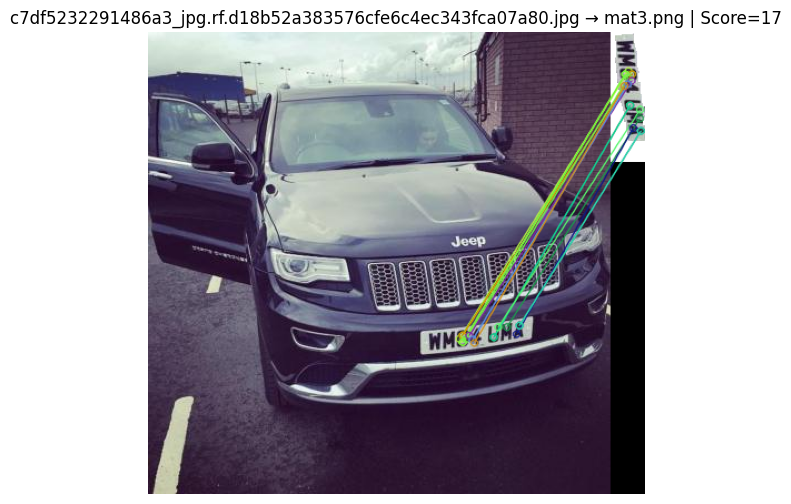


Vérification : b6ecda23586a6ba5_jpg.rf.d737139968dd3f08447305aa7b7f6002.jpg
Descripteurs extraits: (11, 128)
Score obtenu: 1 / 10
X REFUSÉ  : ( 
Score max trouvé : 1


In [25]:
import cv2 as cv
import pandas as pd
import os
import matplotlib.pyplot as plt

# 1️ Chemins
base_dir = os.getcwd()

matricule_folder = os.path.join(base_dir,  "matricules")
plates_folder = os.path.join(base_dir, "License Plates")
csv_path = os.path.join(plates_folder, "_annotations.csv")

# 2️ Charger CSV
df = pd.read_csv(csv_path)
plates_df = df[df["class"] == "license-plate"].copy()

print("Nombre total d'annotations :", len(df))
print("Nombre de plaques trouvées :", len(plates_df))

# 3️ Initialiser SIFT + Matcher
sift = cv.SIFT_create()
bf = cv.BFMatcher()

def extract_sift_from_image(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

# 4️ Construire base autorisée (matricules)
authorized_db = []

for file in os.listdir(matricule_folder):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        path = os.path.join(matricule_folder, file)
        img = cv.imread(path)
        if img is None:
            continue

        kp, des = extract_sift_from_image(img)

        if des is not None:
            authorized_db.append({
                "filename": file,
                "image": img,
                "keypoints": kp,
                "descriptors": des
            })

print("Base autorisée construite :", len(authorized_db))

# 5️ Vérification des voitures test
MATCH_THRESHOLD = 10  # Réduit pour déboguer

def offset_keypoints(keypoints, offset_x, offset_y):
    """Offset keypoints by a given amount"""
    offset_kp = []
    for kp in keypoints:
        new_pt = (kp.pt[0] + offset_x, kp.pt[1] + offset_y)
        new_kp = cv.KeyPoint(new_pt[0], new_pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
        offset_kp.append(new_kp)
    return offset_kp

for _, row in plates_df.iterrows():

    filename = row["filename"]
    path = os.path.join(plates_folder, filename)

    img = cv.imread(path)
    if img is None:
        continue

    #  Découper la plaque depuis le CSV
    xmin, ymin, xmax, ymax = map(int, [row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
    
    #  OPTIMIZATION CONDITION
    if xmin == 0 or ymin == 0:
        print(f"!!!!!  Skipped {filename} (invalid bounding box)")
        continue

    plate = img[ymin:ymax, xmin:xmax]

    # Extraire SIFT sur la plaque seulement
    kp_query, des_query = extract_sift_from_image(plate)

    if des_query is None:
        print(f"!!!!! Skipped {filename} (no SIFT descriptors)")
        continue

    best_score = 0
    best_match = None
    best_good = None

    # Comparaison plaque ↔ plaques autorisées
    for item in authorized_db:

        matches = bf.knnMatch(des_query, item["descriptors"], k=2)

        good = []
        for pair in matches:
            if len(pair) == 2:
                m, n = pair
                if m.distance < 0.75 * n.distance:
                    good.append(m)

        score = len(good)

        if score > best_score:
            best_score = score
            best_match = item
            best_good = good


    # Décision + Affichage

    print("\n=============================================================================================")
    print("Vérification :", filename)
    print(f"Descripteurs extraits: {des_query.shape if des_query is not None else 'None'}")
    print(f"Score obtenu: {best_score} / {MATCH_THRESHOLD}")

    if best_score >= MATCH_THRESHOLD:

        print(" AUTORISÉ : ) ")
        print("Correspond à :", best_match["filename"])
        print("Score :", best_score)

        # 🔹 Offset keypoints from crop to full image coordinates
        kp_query_offsetted = offset_keypoints(kp_query, xmin, ymin)

        result = cv.drawMatches(
            img, kp_query_offsetted,               # voiture complète avec keypoints offsettés
            best_match["image"], best_match["keypoints"],  # matricule base
            best_good, None,
            flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        plt.figure(figsize=(12,6))
        plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
        plt.title(f"{filename} → {best_match['filename']} | Score={best_score}")
        plt.axis("off")
        plt.show()

    else:
        print("X REFUSÉ  : ( ")
        print("Score max trouvé :", best_score)